# Trading Algorithm

In this notebook we will take try a predict which stocks will be daily winners. We will first take a number of fundamental and technical indicators and use random forst model to refine the number of facters and then apply a regreassion model to predict future profit and evaluate the model

## The Data

We will be getting out list of securities from the S&P 500.

the fundametal data will be obttained from Quandl's Core US Fundamentals Data database; this is a paid service!

Closing price will be obtained from yahoo finance using the yFinance library

### Obtaining Data

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# getting the tickers for all the securities in the S&P 500
import pandas as pd

# read_html allows us to get all <table> tags from a website and outputs a list of DataFrames
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies') 
SP500_df = table[0]
security_basket = ['KR', 'CLX', 'LUMN', 'CPB', 'SJM', 'CTXS', 'GIS', 'REGN', 'HRL', 'TIF', 'NEM', 'OTIS', 'CAG', 'GILD', 'WMT', 'DPZ', 'K', 'DG', 'CHD', 'AKAM', 'ATVI', 'EA', 'NLOK', 'CARR', 'AMZN', 'TTWO', 'COST', 'NFLX', 'BDX', 'CHRW', 'VZ', 'KMB', 'EBAY', 'TYL', 'ABMD', 'INCY', 'WST', 'BMY', 'JNJ', 'LLY', 'CL', 'BIO', 'TGT', 'TMO', 'PFE', 'TSCO', 'PG', 'ED', 'ALXN', 'MKC']

In [3]:
# Authenticating Quandl API for fundamental data
import os
from dotenv import load_dotenv
import quandl

load_dotenv()

QUANDL_API_KEY = os.getenv("QUANDL_API_KEY")
quandl.ApiConfig.api_key= QUANDL_API_KEY

In [4]:
# import Yahoo Finance library
import yfinance as yf

In [5]:
from quandl.errors.quandl_error import NotFoundError #to catch errors due to symbols
import datetime

def get_factors(security_basket,start_date, end_date):
    '''
    
    Takes securities from a security basket and pulls daily fundamental indicators
    for each security as well as the closing price
    
    Parameters
    ----------
    
    security_basket: list of str
                    representing tickers.
    
    Returns
    ----------
    
    dataframe of fundamental data and closing price.
    '''
    SP_500 = yf.download('^GSPC', start=start_date, end=end_date) 
    price_df = yf.download(security_basket, start=start_date, end=end_date)    
    portfolio_df = pd.DataFrame()
    for security in security_basket:
        try:
            security_df = quandl.get_table('SHARADAR/DAILY', ticker= security)
            security_df = security_df.set_index('date')
            security_df = security_df.sort_index()
            security_df['close'] = price_df['Close'][security]
            security_df['SP_close'] = SP_500['Close']
            portfolio_df = portfolio_df.append(security_df) 
        except NotFoundError: # if symbol is not found move on to  the next symbol
            pass
    return portfolio_df

In [6]:
start_date = datetime.datetime(2015,1,1) # 2015 was chosen as the start date due to historical limitations of Quandl data 
end_date = datetime.datetime(2020,9,25)
df = get_factors(security_basket, start_date, end_date) # using tickers to create a dataframe with features


# Since we are using paid data we are saving everything into a csv and then reimporting
df.to_csv('data.csv') 
df = pd.DataFrame.from_csv('data.csv')
df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  50 of 50 completed


,ticker,lastupdated,ev,evebit,evebitda,marketcap,pb,pe,ps,close,SP_close
date,,,,,,,,,,,
2015-01-02,KR,2018-10-18,42485.8,14.5,8.8,31213.8,5.9,19.1,0.3,31.764999,2058.199951
2015-01-05,KR,2018-10-18,42264.7,14.5,8.8,30992.7,5.8,19.0,0.3,31.540001,2020.579956
2015-01-06,KR,2018-10-18,42264.7,14.5,8.8,30992.7,5.8,19.0,0.3,31.540001,2002.609985
2015-01-07,KR,2018-10-18,43203.2,14.8,9.0,31931.2,6.0,19.6,0.3,32.494999,2025.900024
2015-01-08,KR,2018-10-18,43797.7,15.0,9.1,32525.7,6.1,19.9,0.3,33.099998,2062.139893


## Feature Engineering

Now that we have all the data that, we need we need to create a label and add factor that pretain to technical signals. Our label will be a simple buy or sell indicator based on whether the return greater than the S&P 500 return and positive.

In [7]:
def create_label(df, security_colunm, benchmark_column):
    '''
    
    calculate whether the 3 month return of a security was positive and beat the 
    3 month return of the benchmark with 1 representing the day the positive 
    return beat the benchamark and 0 representing a day when it was not
    
    Parameters
    ----------
    
    df: dataframe
        Should contain the closing price of the security and the benchmark 
    
    security_colunm: str
        name of column that contains the security closing prices
    
    benchmark_column: str
        name of column that contains the benchmark closing price
    
    Returns
    ----------
    
    copy of inputed dataframe with an added column indicating whether 
    the 3 month returns from security met the criteria or not
    
    '''
    df['return'] = df[security_colunm].rolling(90, min_periods=90).mean().pct_change()
    df['SP_return'] = df[benchmark_column].rolling(90, min_periods=90).mean().pct_change()
    df = df.dropna()
    df['good_trade'] = (df['return'] > 0).astype(int) * (df['return'] > df['SP_return']).astype(int)
    return df

In [8]:
df = df.dropna()
df = create_label(df, 'close', 'SP_close')

In [9]:
df.head()

,ticker,lastupdated,ev,evebit,evebitda,marketcap,pb,pe,ps,close,SP_close,return,SP_return,good_trade
date,,,,,,,,,,,,,,
2015-05-13,KR,2018-10-18,46369.5,14.9,9.2,34981.5,6.5,20.2,0.3,35.615002,2098.479980,0.001192,0.000216,1
2015-05-14,KR,2018-10-18,46963.8,15.1,9.3,35575.8,6.6,20.6,0.3,36.220001,2121.100098,0.001447,0.000538,1
2015-05-15,KR,2018-10-18,47287.9,15.2,9.3,35899.9,6.6,20.8,0.3,36.549999,2122.729980,0.001547,0.000643,1
2015-05-18,KR,2018-10-18,47283.0,15.2,9.3,35895.0,6.6,20.8,0.3,36.544998,2129.199951,0.001249,0.000553,1
2015-05-19,KR,2018-10-18,47469.6,15.2,9.4,36081.6,6.7,20.9,0.3,36.735001,2127.830078,0.001119,0.000351,1


### Technical signals

We will now use the closing price to create some technical signals. To create the signals we are using the following:

**Simple moving average:**

>SMA = (A<sub>1</sub>+A<sub>2</sub>+...+A<sub>n</sub>)/n

> ***where:***

>A = Average in period n

>n = number of time periods

**Exponential Moving Average:**

>EMA<sub>t</sub> =[V<sub>t</sub> * (s/1+d)]+EMA<sub>y</sub> * [1−(s/1+d )]

> ***where:***

>EMA<sub>t</sub> = EMA today

>V<sub>t</sub> = Value today

>EMA<sub>y</sub> = EMA Yesterday

>s = smoothing

>d = number of days

**Rate of Change**

> ROC = (Y<sub>2</sub> - Y<sub>1</sub>)/ (X<sub>2</sub> - X<sub>1</sub>)

> **Where**

>Y = price

>X = period

**Price Momentum**

**Bollinger Bands**

In [10]:
def MA(df, n):
    '''
    
    calculates the moving average
    
    Parameters
    ----------
    
    df: dataframe
        dataframe with closing price
        
    n: int
        Window for moving average
    
    Returns
    ----------
    
    Series with the moving average
    
    '''
    MA = pd.Series(df["close"].rolling(n, min_periods=n).mean())
    return MA

In [11]:
def EMA(data, n):
    '''
    
    calculates the exponential moving average
    
    Parameters
    ----------
    
    df: dataframe
        dataframe with closing price
        
    n: int
        Window for moving average
    
    Returns
    ----------
    
    Series with the exponential moving average
    
    '''
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean())
    return EMA

In [12]:
def ROC(data, n):
    '''
    
    calculates the rate of change
    
    Parameters
    ----------
    
    data: Series
        series of closing price
        
    n: int
        Window for moving average
    
    Returns
    ----------
    
    Series with the rate of change
    
    '''
    M = data.diff(n - 1)  
    N = data.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100))   
    return ROC

In [13]:
def MOM(data, n): 
    '''
    
    calculates the price momentum
    
    Parameters
    ----------
    
    data: Series
        series of closing price
        
    n: int
        Window for moving average
    
    Returns
    ----------
    
    Series with the price momentum
    
    '''
    MOM = pd.Series(data.diff(n))   
    return MOM

In [14]:
import numpy as np

def bolinger(df, bollinger_window):
    '''
    
    calculates various bollinger bands
    
    Parameters
    ----------
    
    df: dataframe
        dataframe with closing prices
        
    n: int
        Window for moving average
    
    Returns
    ----------
    
    input dataframe with new column reprsenting the various bollinger bands
    
    '''
    # Calculate rolling mean and standard deviation
    df['bollinger_mid_band'] = df['close'].rolling(window=bollinger_window).mean()
    df['bollinger_std'] = df['close'].rolling(window=bollinger_window).std()

    # Calculate upper and lowers bands of bollinger band
    df['bollinger_upper_band']  = df['bollinger_mid_band'] + (df['bollinger_std'] * 1)
    df['bollinger_lower_band']  = df['bollinger_mid_band'] - (df['bollinger_std'] * 1)

    # Calculate bollinger band trading signal
    df['bollinger_long'] = np.where(df['close'] < df['bollinger_lower_band'], 1.0, 0.0)
    df['bollinger_short'] = np.where(df['close'] > df['bollinger_upper_band'], -1.0, 0.0)
    df['bollinger_signal'] = df['bollinger_long'] + df['bollinger_short']
    
    return df

In [15]:
def make_technical_signals(df, short_window, long_window):
    '''
    
    creates trade signals based on technical indiacators
    
    Parameters
    ----------
    
    df: dataframe
        dataframe with the close price
    
    short_window: integer
        short window
    
    long_window: integer
        long window
        
    Returns
    ----------
    
    returns the inputed dataframe with trade signals
    
    '''
    # get short and long term simple moving averages
    df[f'MA {short_window}'] = MA(df, short_window)
    df[f'MA {long_window}'] = MA(df, long_window)
    
    # get short and long term exponential moving averages
    df[f'EMA {short_window}'] = MA(df, short_window)
    df[f'EMA {long_window}'] = MA(df, long_window)
    
    
    df['ROC21'] = ROC(df['close'], 21)
    df['ROC63'] = ROC(df['close'], 63)
    
    df['MOM21'] = MOM(df['close'], 21)
    df['MOM63'] = MOM(df['close'], 63)
    
    bollinger_window = 20
    df = bolinger(df, bollinger_window)
    return df.dropna()

In [16]:
df = make_technical_signals(df, 50, 100)
df.head()

,ticker,lastupdated,ev,evebit,evebitda,marketcap,pb,pe,ps,close,...,ROC63,MOM21,MOM63,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
date,,,,,,,,,,,,,,,,,,,,,
2015-10-02,KR,2018-10-18,47155.4,13.8,8.7,36153.4,6.1,18.7,0.3,37.139999,...,-1.472345,2.489998,0.355000,36.2485,0.980254,37.228754,35.268246,0.0,0.0,0.0
2015-10-05,KR,2018-10-18,48060.6,14.0,8.8,37058.6,6.3,19.2,0.3,38.070000,...,1.317362,3.500000,0.375000,36.4485,0.918495,37.366995,35.530005,0.0,-1.0,-1.0
2015-10-06,KR,2018-10-18,47145.6,13.8,8.7,36143.6,6.1,18.7,0.3,37.130001,...,-1.733489,3.060001,-0.445000,36.5525,0.868191,37.420691,35.684309,0.0,0.0,0.0
2015-10-07,KR,2018-10-18,47515.5,13.9,8.7,36513.5,6.2,18.9,0.3,37.509998,...,-1.729106,2.459999,-0.275002,36.7080,0.729863,37.437863,35.978137,0.0,-1.0,-1.0
2015-10-08,KR,2018-10-18,47992.5,14.0,8.8,36990.5,6.3,19.1,0.3,38.000000,...,-1.234564,3.599998,-0.169998,36.8380,0.716046,37.554046,36.121954,0.0,-1.0,-1.0


Now that we have several features, to simplify the model we will be removing the features that do not impact the good trade signal. To figure out which features hold the least amount of importance we will be running a XGBoost classifier and using the feature importance function. We will first split the features from the label, then split our X and y into training and testing and then scale the train and test feature data for the non binary features

In [17]:
X = df.reset_index().drop(columns=['ticker', 'lastupdated', 'good_trade','date','close','SP_close','return','SP_return']) # getting all the features
y = df['good_trade'] # getting the label

In [18]:
X.head()

,ev,evebit,evebitda,marketcap,pb,pe,ps,MA 50,MA 100,EMA 50,...,ROC63,MOM21,MOM63,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
0,47155.4,13.8,8.7,36153.4,6.1,18.7,0.3,36.7386,36.83400,36.7386,...,-1.472345,2.489998,0.355000,36.2485,0.980254,37.228754,35.268246,0.0,0.0,0.0
1,48060.6,14.0,8.8,37058.6,6.3,19.2,0.3,36.7328,36.85855,36.7328,...,1.317362,3.500000,0.375000,36.4485,0.918495,37.366995,35.530005,0.0,-1.0,-1.0
2,47145.6,13.8,8.7,36143.6,6.1,18.7,0.3,36.7114,36.86765,36.7114,...,-1.733489,3.060001,-0.445000,36.5525,0.868191,37.420691,35.684309,0.0,0.0,0.0
3,47515.5,13.9,8.7,36513.5,6.2,18.9,0.3,36.6872,36.87725,36.6872,...,-1.729106,2.459999,-0.275002,36.7080,0.729863,37.437863,35.978137,0.0,-1.0,-1.0
4,47992.5,14.0,8.8,36990.5,6.3,19.1,0.3,36.6712,36.89180,36.6712,...,-1.234564,3.599998,-0.169998,36.8380,0.716046,37.554046,36.121954,0.0,-1.0,-1.0


In [19]:
y.head()

date
2015-10-02    1
2015-10-05    1
2015-10-06    1
2015-10-07    1
2015-10-08    1
Name: good_trade, dtype: int32

In [20]:
# Splitting into Train and Test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)


from sklearn.preprocessing import MinMaxScaler

# Creating StandardScaler instance
scaler = MinMaxScaler()

# Fitting Standard Scaler
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# adding back scaled data
X_train[list(X_train.columns) ] = X_train_scaled
X_test[list(X_test.columns) ] = X_test_scaled

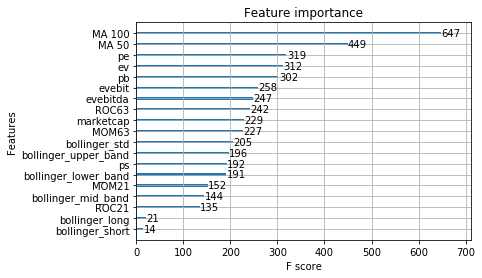

In [22]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)

# plot feature importance
plot_importance(model)
pyplot.show()

The f with the numeric subscript tells us the index 0 to 6 which is based off of the feature columns from the X_train dataframe. We can then conclude in accordance to importance the feature are ranked as follows:

100 day moving average

50 day moving average

pe - price to earnings

EV - Enterprise value

pb - price to book

evebit - earnings before interest and taxes

evebitda - earnings before interest and taxes and amortization

63 day rate of change

MarketCap

63 day price momentum

bollinger standard deviation

bollinger upper band

ps - price to sales

bollinger lower band

21 day price momentum

bollinger mid band

21 day rate of change

bollinger long

bollinger short